## No need to run first cell its for file arrange

In [ ]:
import os
import shutil

# Define source directories
source_dirs = ["hurricane-florence", "hurricane-harvey","midwest-flooding","santa-rosa-wildfire"]
target_dir = "hurricane_flood_fire"

# Create target directories
os.makedirs(os.path.join(target_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(target_dir, "labels"), exist_ok=True)

# Copy post images and labels
for hurricane in source_dirs:
    image_src = os.path.join(hurricane, "images", "post")
    label_src = os.path.join(hurricane, "labels", "post")

    if os.path.exists(image_src):
        for file in os.listdir(image_src):
            src_path = os.path.join(image_src, file)
            dest_path = os.path.join(target_dir, "images", file)
            shutil.copy2(src_path, dest_path)

    if os.path.exists(label_src):
        for file in os.listdir(label_src):
            src_path = os.path.join(label_src, file)
            dest_path = os.path.join(target_dir, "labels", file)
            shutil.copy2(src_path, dest_path)

print("✅ Files copied successfully!")

In [2]:
import torch

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3060 Laptop GPU


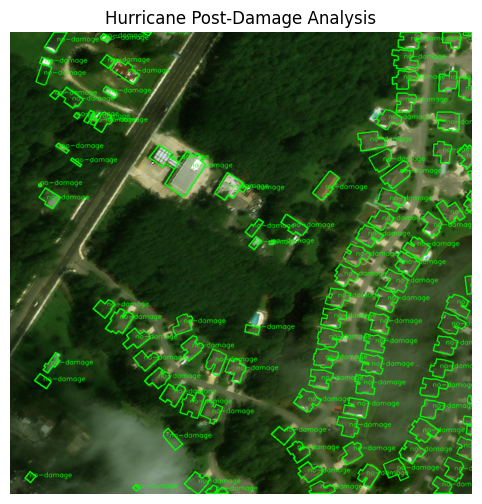

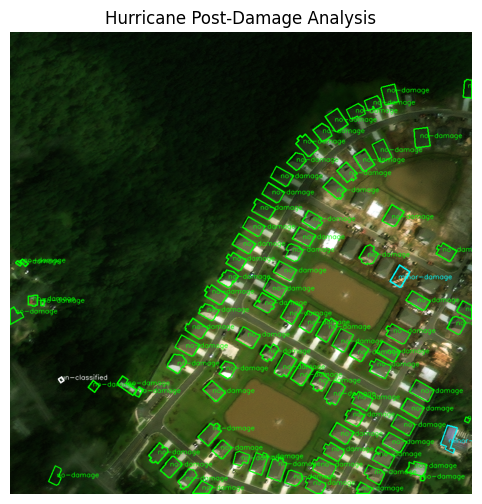

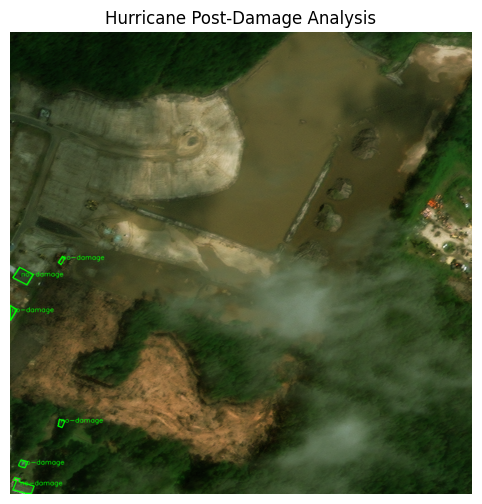

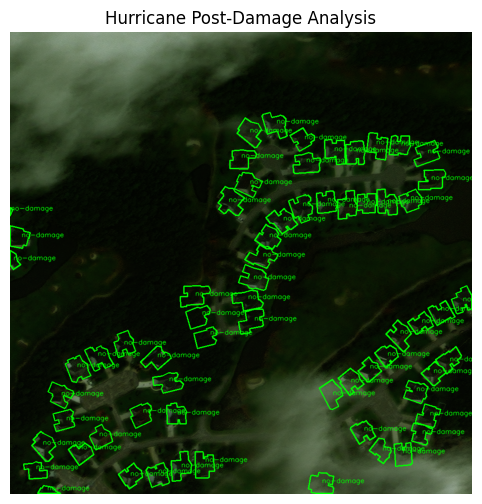

In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt


dataset_dir = r"C:\Users\yanit\OneDrive\Bureau\AI Disaster\hurricane_flood"

json_dir = os.path.join(dataset_dir, "labels")
image_dir = os.path.join(dataset_dir, "images")

damage_colors = {
    "no-damage": (0, 255, 0),      
    "minor-damage": (255, 255, 0), 
    "major-damage": (255, 165, 0), 
    "destroyed": (255, 0, 0)       
}

def extract_polygons(max_images=4):
    if not os.path.exists(json_dir):
        print(f"Error: Label folder not found at {json_dir}")
        return

    count = 0
    for json_file in os.listdir(json_dir):
        if not json_file.endswith(".json"):
            continue

        json_path = os.path.join(json_dir, json_file)
        with open(json_path, "r") as f:
            data = json.load(f)

        image_name = data.get("metadata", {}).get("img_name")
        if not image_name:
            print(f"Warning: 'img_name' missing in {json_file}, skipping.")
            continue

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        for building in data.get("features", {}).get("xy", []):
            wkt_string = building.get("wkt", "")
            if not wkt_string.startswith("POLYGON (("):
                continue

            coords = wkt_string[10:-2].split(", ")
            polygon = np.array([list(map(float, coord.split())) for coord in coords])

            label = building.get("properties", {}).get("subtype", "unknown")
            color = damage_colors.get(label, (255, 255, 255))

            pts = polygon.reshape((-1, 1, 2)).astype(np.int32)
            cv2.polylines(image, [pts], isClosed=True, color=color, thickness=2)

            if len(polygon) > 0:
                centroid = np.mean(polygon, axis=0).astype(int)
                cv2.putText(image, label, tuple(centroid), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 1, cv2.LINE_AA)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Hurricane Post-Damage Analysis")
        plt.axis("off")
        plt.show()

        count += 1
        if count >= max_images:
            break

extract_polygons(max_images=4)

In [ ]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

dataset_dir = r"C:\Users\yanit\OneDrive\Bureau\AI Disaster\hurricane_flood"

damage_classes = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Using device: {device}")

class DisasterDataset(Dataset):
    def __init__(self, transform=None):
        """Dataset for extracting post-disaster building images and labels."""
        self.image_dir = os.path.join(dataset_dir, "images")
        self.json_dir = os.path.join(dataset_dir, "labels")
        self.transform = transform
        self.samples = []

        print("🔄 Loading dataset...")
        self._load_data()
        print(f"✅ Dataset loaded: {len(self.samples)} samples found.")

    def _load_data(self):
        """Loads image paths, polygons, and labels from the dataset."""
        if not os.path.exists(self.json_dir):
            print(f"❌ Label directory not found: {self.json_dir}")
            return

        image_building_count = {}  

        for json_file in os.listdir(self.json_dir):
            if not json_file.endswith(".json"):
                continue

            json_path = os.path.join(self.json_dir, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            image_name = data["metadata"].get("img_name")
            if image_name is None:
                print(f"⚠️ Warning: 'img_name' missing in {json_file}, skipping.")
                continue

            image_path = os.path.join(self.image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"⚠️ Missing image: {image_path}, skipping.")
                continue

            building_count = 0 

            for building in data["features"]["xy"]:
                wkt_string = building["wkt"]
                if not wkt_string.startswith("POLYGON (("):
                    continue

                coords = wkt_string[10:-2].split(", ")
                polygon = np.array([list(map(float, coord.split())) for coord in coords])

                label = building["properties"]["subtype"]
                uid = building["properties"].get("uid") 
                if label not in damage_classes:
                    continue

                self.samples.append((image_path, polygon, damage_classes[label],uid))
                building_count += 1
            image_building_count[image_name] = building_count

        print("\n📊 Number of extracted buildings per image (first 10):")
        for i, (image_name, count) in enumerate(image_building_count.items()):
            print(f"{i + 1}. {image_name}: {count} buildings")
            if i == 20:  
                break

    def __len__(self):
        return len(self.samples)

    def _crop_building(self, image, polygon):
        """Extracts a cropped building image from the full image."""
        x_min, y_min = polygon.min(axis=0).astype(int)
        x_max, y_max = polygon.max(axis=0).astype(int)

        cropped = image[y_min:y_max, x_min:x_max]
        return cropped

    def __getitem__(self, idx):
        """Retrieves a (cropped building image, label, image_name, uid) pair."""
        image_path, polygon, label,uid= self.samples[idx]  
        image_name = os.path.basename(image_path) 
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Could not read image: {image_path}, skipping.")
            return None

        cropped = self._crop_building(image, polygon)

        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            print(f"⚠️ Skipping empty crop in {image_path}")
            return None

        cropped = cv2.resize(cropped, (224, 224))
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
        cropped = torch.tensor(cropped, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            cropped = self.transform(cropped)

        return cropped, label, image_name,uid

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),  # Flip 
    transforms.RandomRotation(20),  # Rotate 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2), 
    transforms.ToTensor(), # Color var
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalization
])

print("📂 Initializing dataset...")
dataset = DisasterDataset(transform=transform)

dataset.samples = [sample for sample in dataset.samples if sample is not None]

print("🛠️ Creating DataLoader...")
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=13)

#print("🔄 Loading first batch...")
#for batch in dataloader:
 #   images, labels = batch
  #  images, labels = images.to(device), labels.to(device)
   # print(f"✅ Batch loaded : Images shape {images.shape}, Labels shape {labels.shape}")
    #break

#print("🎉 Dataset and DataLoader setup complete!")

⚡ Using device: cuda
📂 Initializing dataset...
🔄 Loading dataset...

📊 Number of extracted buildings per image (first 10):
1. hurricane-florence_00000000_post_disaster.png: 110 buildings
2. hurricane-florence_00000001_post_disaster.png: 90 buildings
3. hurricane-florence_00000002_post_disaster.png: 6 buildings
4. hurricane-florence_00000003_post_disaster.png: 66 buildings
5. hurricane-florence_00000008_post_disaster.png: 22 buildings
6. hurricane-florence_00000012_post_disaster.png: 36 buildings
7. hurricane-florence_00000015_post_disaster.png: 106 buildings
8. hurricane-florence_00000016_post_disaster.png: 67 buildings
9. hurricane-florence_00000018_post_disaster.png: 47 buildings
10. hurricane-florence_00000020_post_disaster.png: 11 buildings
11. hurricane-florence_00000022_post_disaster.png: 6 buildings
12. hurricane-florence_00000023_post_disaster.png: 3 buildings
13. hurricane-florence_00000024_post_disaster.png: 15 buildings
14. hurricane-florence_00000026_post_disaster.png: 27 b

In [ ]:
print(f"Dataset sample: {dataset[0]}")  

Dataset sample: (tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ImprovedDamageClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.5):
        super(ImprovedDamageClassifier, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1]) 

        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for layer in list(self.resnet.children())[-3:]:  #ici unfreeze
            for param in layer.parameters():
                param.requires_grad = True

        self.fc1 = nn.Linear(2048, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1) 

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedDamageClassifier(num_classes=4).to(device)

save_path = r"C:\Users\yanit\OneDrive\Bureau\AI Disaster\improved_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)
print(f"✅ Model saved successfully at: {save_path}")

C:\Users\yanit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yanit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model saved successfully at: C:\Users\yanit\OneDrive\Bureau\AI Disaster\improved_model.pth


In [ ]:
import torch
from sklearn.metrics import f1_score
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

##changed from ai2
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

num_epochs = 30

for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs} starting...")

    # Training phase
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch_idx, (images, labels,image_names, uids) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
            batch_f1 = f1_score(all_labels, all_preds, average="macro")
            print(f"🟢 Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"\n✅ Epoch {epoch+1} Training Done - Avg Loss: {total_loss/len(train_loader):.4f}, F1: {train_f1:.4f}")

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    image_names, building_uids = [], []  

    with torch.no_grad():
        for batch_idx, (images, labels, img_names, uids) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
            image_names.extend(img_names)  
            building_uids.extend(uids) 

            if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                batch_f1 = f1_score(val_labels, val_preds, average="macro")
                print(f"🔵 Validation Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    print(f"\n📊 Epoch {epoch+1} Summary - Train Loss: {total_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}")

print("\n🎉 Training complete!")


🔄 Epoch 1/30 starting...
🟢 Batch 1/299 - Loss: 1.4938, F1: 0.2006
🟢 Batch 10/299 - Loss: 1.2683, F1: 0.2904
🟢 Batch 20/299 - Loss: 1.0834, F1: 0.3702
🟢 Batch 30/299 - Loss: 1.0707, F1: 0.3985
🟢 Batch 40/299 - Loss: 0.8968, F1: 0.4136
🟢 Batch 50/299 - Loss: 0.9255, F1: 0.4192
🟢 Batch 60/299 - Loss: 0.9532, F1: 0.4207
🟢 Batch 70/299 - Loss: 1.0154, F1: 0.4220
🟢 Batch 80/299 - Loss: 0.8741, F1: 0.4217
🟢 Batch 90/299 - Loss: 0.8544, F1: 0.4232
🟢 Batch 100/299 - Loss: 0.7372, F1: 0.4257
🟢 Batch 110/299 - Loss: 0.7615, F1: 0.4271
🟢 Batch 120/299 - Loss: 0.7986, F1: 0.4271
🟢 Batch 130/299 - Loss: 0.8247, F1: 0.4275
🟢 Batch 140/299 - Loss: 0.7918, F1: 0.4279
🟢 Batch 150/299 - Loss: 0.8323, F1: 0.4279
🟢 Batch 160/299 - Loss: 0.7998, F1: 0.4280
🟢 Batch 170/299 - Loss: 0.7555, F1: 0.4280
🟢 Batch 180/299 - Loss: 0.9271, F1: 0.4282
🟢 Batch 190/299 - Loss: 0.7809, F1: 0.4285
🟢 Batch 200/299 - Loss: 0.7464, F1: 0.4273
🟢 Batch 210/299 - Loss: 0.7551, F1: 0.4295
🟢 Batch 220/299 - Loss: 0.8208, F1: 0.4

In [61]:
import pandas as pd

val_predictions_df = pd.DataFrame({
    'Image Name': image_names,
    'Building UID': building_uids,
    'True Labels': val_labels,
    'Predicted Labels': val_preds
})

val_predictions_df.to_csv('val_predictions3.csv', index=False)
print("📂 Predictions saved successfully !")

📂 Predictions saved successfully !


In [62]:
from sklearn.metrics import classification_report

class_report = classification_report(val_labels, val_preds, digits=4)
print("\n📜 Classification Report:\n", class_report)

final_f1_macro = f1_score(val_labels, val_preds, average="macro")
print(f"\n🏆 Final Macro F1 Score: {final_f1_macro:.4f}")


📜 Classification Report:
               precision    recall  f1-score   support

           0     0.8572    0.8666    0.8619      4799
           1     0.2606    0.2186    0.2378       590
           2     0.6589    0.6877    0.6730      1963
           3     0.3088    0.1875    0.2333       112

    accuracy                         0.7582      7464
   macro avg     0.5214    0.4901    0.5015      7464
weighted avg     0.7496    0.7582    0.7534      7464


🏆 Final Macro F1 Score: 0.5015


<Figure size 1600x1100 with 0 Axes>

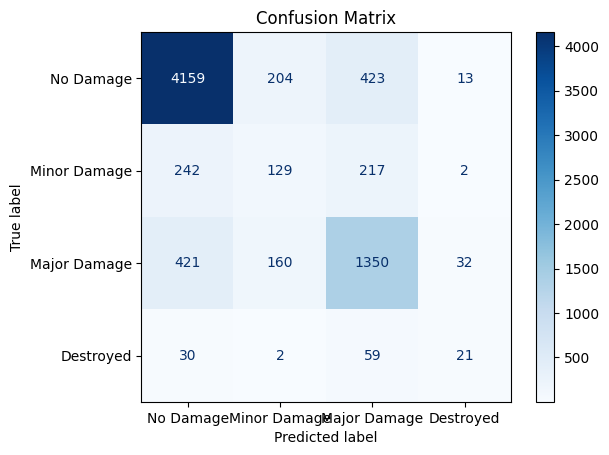

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(16, 11))
cmd = ConfusionMatrixDisplay(cm, display_labels=['No Damage', 'Minor Damage', 'Major Damage', 'Destroyed'])
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### DOWNWARD FROM HERE IS TRIAL AND ERROR

In [ ]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

dataset_dir = r"C:\Users\yanit\OneDrive\Bureau\AI Disaster\hurricane_flood"

damage_classes = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified":4
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Using device: {device}")

class DisasterDataset(Dataset):
    def __init__(self, transform=None):
        """Dataset for extracting post-disaster building images and labels."""
        self.image_dir = os.path.join(dataset_dir, "images")
        self.json_dir = os.path.join(dataset_dir, "labels")
        self.transform = transform
        self.samples = []

        print("🔄 Loading dataset...")
        self._load_data()
        print(f"✅ Dataset loaded: {len(self.samples)} samples found.")

    def _load_data(self):
        """Loads image paths, polygons, and labels from the dataset."""
        if not os.path.exists(self.json_dir):
            print(f"❌ Label directory not found: {self.json_dir}")
            return

        image_building_count = {}  

        for json_file in os.listdir(self.json_dir):
            if not json_file.endswith(".json"):
                continue

            json_path = os.path.join(self.json_dir, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            image_name = data["metadata"].get("img_name")
            if image_name is None:
                print(f"⚠️ Warning: 'img_name' missing in {json_file}, skipping.")
                continue

            image_path = os.path.join(self.image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"⚠️ Missing image: {image_path}, skipping.")
                continue

            building_count = 0  

            for building in data["features"]["xy"]:
                wkt_string = building["wkt"]
                if not wkt_string.startswith("POLYGON (("):
                    continue

                coords = wkt_string[10:-2].split(", ")
                polygon = np.array([list(map(float, coord.split())) for coord in coords])

                label = building["properties"]["subtype"]
                uid = building["properties"].get("uid") 

                if label not in damage_classes:
                    print(f"⚠️ Warning: Unknown label '{label}' in {json_file}, skipping.")
                    continue

                label = damage_classes[label] 

                self.samples.append((image_path, polygon, label, uid))
                building_count += 1
            image_building_count[image_name] = building_count

        print("\n📊 Number of extracted buildings per image (first 10):")
        for i, (image_name, count) in enumerate(image_building_count.items()):
            print(f"{i + 1}. {image_name}: {count} buildings")
            if i == 20: 
                break

    def __len__(self):
        return len(self.samples)

    def _crop_building(self, image, polygon):
        """Extracts a cropped building image from the full image."""
        x_min, y_min = polygon.min(axis=0).astype(int)
        x_max, y_max = polygon.max(axis=0).astype(int)

        cropped = image[y_min:y_max, x_min:x_max]
        return cropped

    def __getitem__(self, idx):
        """Retrieves a (cropped building image, label, image_name, uid) pair."""
        image_path, polygon, label, uid = self.samples[idx]  
        image_name = os.path.basename(image_path)  

        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Could not read image: {image_path}, skipping.")
            return None

        cropped = self._crop_building(image, polygon)

        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            print(f"⚠️ Skipping empty crop in {image_path}")
            return None

        cropped = cv2.resize(cropped, (224, 224))
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
        cropped = torch.tensor(cropped, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            cropped = self.transform(cropped)

        # Ensure label is an integer (CrossEntropyLoss requires integer labels)
        label = int(label)  # This ensures the label is an integer (it should be, since damage_classes maps to integers)

        return cropped, label, image_name, uid

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoom-in randomness
    transforms.RandomHorizontalFlip(),  # Flip horizontally
    transforms.RandomRotation(20),  # Rotate image slightly
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2), 
    transforms.ToTensor(), # Color variation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

print("📂 Initializing dataset...")
dataset = DisasterDataset(transform=transform)

dataset.samples = [sample for sample in dataset.samples if sample is not None]

print("🛠️ Creating DataLoader...")
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=13)

#print("🔄 Loading first batch...")
#for batch in dataloader:
 #   images, labels = batch
  #  images, labels = images.to(device), labels.to(device)
   # print(f"✅ Batch loaded : Images shape {images.shape}, Labels shape {labels.shape}")
    #break

#print("🎉 Dataset and DataLoader setup complete!")

⚡ Using device: cuda
📂 Initializing dataset...
🔄 Loading dataset...

📊 Number of extracted buildings per image (first 10):
1. hurricane-florence_00000000_post_disaster.png: 110 buildings
2. hurricane-florence_00000001_post_disaster.png: 91 buildings
3. hurricane-florence_00000002_post_disaster.png: 6 buildings
4. hurricane-florence_00000003_post_disaster.png: 66 buildings
5. hurricane-florence_00000008_post_disaster.png: 23 buildings
6. hurricane-florence_00000012_post_disaster.png: 36 buildings
7. hurricane-florence_00000015_post_disaster.png: 106 buildings
8. hurricane-florence_00000016_post_disaster.png: 67 buildings
9. hurricane-florence_00000018_post_disaster.png: 47 buildings
10. hurricane-florence_00000020_post_disaster.png: 13 buildings
11. hurricane-florence_00000022_post_disaster.png: 8 buildings
12. hurricane-florence_00000023_post_disaster.png: 3 buildings
13. hurricane-florence_00000024_post_disaster.png: 15 buildings
14. hurricane-florence_00000026_post_disaster.png: 28 b

In [57]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from sklearn.metrics import f1_score


num_epochs = 21
for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs} starting...")

    # Training phase
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch_idx, (images, labels, img_names, uids) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels
        preds = torch.argmax(outputs, dim=1)

        # Move to CPU first, then append to the list
        all_preds.extend(preds.cpu().numpy())  # Make sure preds are moved to the CPU
        all_labels.extend(labels.cpu().numpy())  # Ensure labels are on CPU before appending

        if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
            batch_f1 = f1_score(all_labels, all_preds, average="macro")
            print(f"🟢 Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    # After collecting all labels, convert them to NumPy
    labels_imbalance = np.array(all_labels, dtype=int)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels_imbalance),  # Unique labels
        y=labels_imbalance  # Use the accumulated labels for class weighting
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Define the criterion with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"\n✅ Epoch {epoch+1} Training Done - Avg Loss: {total_loss/len(train_loader):.4f}, F1: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    image_names, building_uids = [], []  # Track image names & UIDs

    with torch.no_grad():
        for batch_idx, (images, labels, img_names, uids) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
            image_names.extend(img_names)  # Store filenames
            building_uids.extend(uids)  # Store UIDs

            if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                batch_f1 = f1_score(val_labels, val_preds, average="macro")
                print(f"🔵 Validation Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    print(f"\n📊 Epoch {epoch+1} Summary - Train Loss: {total_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}")

print("\n🎉 Training complete!")


🔄 Epoch 1/21 starting...
🟢 Batch 1/299 - Loss: 1.5110, F1: 0.2194
🟢 Batch 10/299 - Loss: 1.9096, F1: 0.1733
🟢 Batch 20/299 - Loss: 1.5576, F1: 0.1645
🟢 Batch 30/299 - Loss: 1.8858, F1: 0.1768
🟢 Batch 40/299 - Loss: 2.2669, F1: 0.1818
🟢 Batch 50/299 - Loss: 2.0275, F1: 0.1875
🟢 Batch 60/299 - Loss: 1.4875, F1: 0.1895
🟢 Batch 70/299 - Loss: 1.4584, F1: 0.1887
🟢 Batch 80/299 - Loss: 1.6243, F1: 0.1892
🟢 Batch 90/299 - Loss: 1.7801, F1: 0.1888
🟢 Batch 100/299 - Loss: 1.3517, F1: 0.1878
🟢 Batch 110/299 - Loss: 2.2457, F1: 0.1832
🟢 Batch 120/299 - Loss: 1.5971, F1: 0.1800
🟢 Batch 130/299 - Loss: 1.6755, F1: 0.1788
🟢 Batch 140/299 - Loss: 1.8239, F1: 0.1786
🟢 Batch 150/299 - Loss: 1.7814, F1: 0.1787
🟢 Batch 160/299 - Loss: 1.5576, F1: 0.1788
🟢 Batch 170/299 - Loss: 1.4094, F1: 0.1790
🟢 Batch 180/299 - Loss: 2.1501, F1: 0.1814
🟢 Batch 190/299 - Loss: 1.5970, F1: 0.1820
🟢 Batch 200/299 - Loss: 1.7633, F1: 0.1811
🟢 Batch 210/299 - Loss: 1.9834, F1: 0.1794
🟢 Batch 220/299 - Loss: 1.8379, F1: 0.1

KeyboardInterrupt: 

In [47]:
from imblearn.over_sampling import SMOTE
import torch
import numpy as np
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset

# Create the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

num_epochs = 1
for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs} starting...")

    # Training phase
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    # Collect the training data before SMOTE
    train_images = []
    train_labels = []
    for batch_idx, (images, labels, img_names, uids) in enumerate(train_loader):
        train_images.extend(images.numpy())
        train_labels.extend(labels.numpy())

    # Convert data to numpy arrays for SMOTE
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    # Apply SMOTE to balance the class distribution
    train_images_resampled, train_labels_resampled = smote.fit_resample(train_images, train_labels)

    # Convert back to torch tensors
    train_images_resampled = torch.tensor(train_images_resampled, dtype=torch.float32).to(device)
    train_labels_resampled = torch.tensor(train_labels_resampled, dtype=torch.long).to(device)

    # Create a new DataLoader with the resampled data
    resampled_dataset = TensorDataset(train_images_resampled, train_labels_resampled)
    resampled_train_loader = DataLoader(resampled_dataset, batch_size=100, shuffle=True)

    for batch_idx, (images, labels, img_names, uids) in enumerate(resampled_train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels
        preds = torch.argmax(outputs, dim=1)

        # Move to CPU first, then append to the list
        all_preds.extend(preds.cpu().numpy())  # Make sure preds are moved to the CPU
        all_labels.extend(labels.cpu().numpy())  # Ensure labels are on CPU before appending

        if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
            batch_f1 = f1_score(all_labels, all_preds, average="macro")
            print(f"🟢 Batch {batch_idx+1}/{len(resampled_train_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    # Compute class weights if needed
    labels_imbalance = np.array(all_labels, dtype=int)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_imbalance), y=labels_imbalance)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Define the criterion with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"\n✅ Epoch {epoch+1} Training Done - Avg Loss: {total_loss/len(resampled_train_loader):.4f}, F1: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    image_names, building_uids = [], []  # Track image names & UIDs

    with torch.no_grad():
        for batch_idx, (images, labels, img_names, uids) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
            image_names.extend(img_names)  # Store filenames
            building_uids.extend(uids)  # Store UIDs

            if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                batch_f1 = f1_score(val_labels, val_preds, average="macro")
                print(f"🔵 Validation Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    print(f"\n📊 Epoch {epoch+1} Summary - Train Loss: {total_loss/len(resampled_train_loader):.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}")

print("\n🎉 Training complete!")


🔄 Epoch 1/1 starting...


KeyboardInterrupt: 